<a href="https://colab.research.google.com/github/ibrahimba9/New_York_Taxi_Trips/blob/main/NY_Taxi_Fare_Prediction_PySpark_Google_Colab_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# got to kaggele > profile > account > scroll down > click exprire api token > click on create new api token

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

In [5]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ibrahimbenabdallah","key":"634fe495234e4524eb0d822988e03dd5"}'}

In [6]:
!mkdir ~/.kaggle

In [7]:
!cp kaggle.json ~/.kaggle/

In [8]:
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-05-15 08:36:45           5182  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           2892  
mathurinache/twitter-edge-nodes                             Twitter Edge Nodes                                342MB  2021-03-08 06:43:04            322  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1746  
imsparsh/musicnet-dataset                                   MusicNet Dataset

In [10]:
! kaggle competitions download -c 'new-york-city-taxi-fare-prediction'

 99% 1.55G/1.56G [00:19<00:00, 86.7MB/s]
100% 1.56G/1.56G [00:19<00:00, 85.7MB/s]
  0% 0.00/960k [00:00<?, ?B/s]
100% 960k/960k [00:00<00:00, 133MB/s]
  0% 0.00/486 [00:00<?, ?B/s]
100% 486/486 [00:00<00:00, 400kB/s]
  0% 0.00/335k [00:00<?, ?B/s]
100% 335k/335k [00:00<00:00, 43.7MB/s]


In [11]:
! mkdir taxi_data

In [12]:
!unzip train.csv.zip -d taxi_data

Archive:  train.csv.zip
  inflating: taxi_data/train.csv     


In [13]:
!mv test.csv taxi_data

In [14]:
!ls

GCP-Coupons-Instructions.rtf  sample_data	     taxi_data
kaggle.json		      sample_submission.csv  train.csv.zip


In [15]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz

!pip install -q findspark
!pip install pyspark==2.4.5
!pip install -U pyarrow

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:11 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/u

In [16]:
import findspark
from pyspark.sql import SparkSession
import sys,tempfile
import urllib.request
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType, DoubleType, TimestampType, FloatType
from pyspark.sql.functions import udf, radians, sqrt, sin, asin, cos, acos, col, array, isnan, when, count, col
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.feature import SQLTransformer
from pyspark.ml import Pipeline

In [17]:
findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.executor.memory", "4g")
spark.conf.set("spark.driver.memory", "4g")
spark.conf.set("spark.memory.fraction", "0.9")


In [16]:
df = spark.read.option("inferSchema", "false").csv("taxi_data/train.csv", header=True)
df.printSchema()

root
 |-- key: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- passenger_count: string (nullable = true)



In [17]:
df.show()

+--------------------+-----------+--------------------+----------------+---------------+-----------------+----------------+---------------+
|                 key|fare_amount|     pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+--------------------+-----------+--------------------+----------------+---------------+-----------------+----------------+---------------+
|2009-06-15 17:26:...|        4.5|2009-06-15 17:26:...|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|
|2010-01-05 16:52:...|       16.9|2010-01-05 16:52:...|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|
|2011-08-18 00:35:...|        5.7|2011-08-18 00:35:...|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|
|2012-04-21 04:30:...|        7.7|2012-04-21 04:30:...|       -73.98713|      40.733143|       -73.991567|       40.758092|              1|
|2010-03-09 07:51:..

In [18]:
schema = StructType([
          StructField("key", TimestampType(), True),
          StructField("fare_amount", DoubleType(), True),
          StructField("pickup_datetime", TimestampType(), True),
          StructField("pickup_longitude", DoubleType(), True),
          StructField("pickup_latitude", DoubleType(), True),
          StructField("dropoff_longitude", DoubleType(), True),
          StructField("dropoff_latitude", DoubleType(), True),
          StructField("passenger_count", IntegerType(), True)
])
          

print(schema)

df = spark.read.csv("taxi_data/train.csv", header=True, schema=schema, enforceSchema=True, timestampFormat="yyyy-MM-dd HH:mm:ss")

StructType(List(StructField(key,TimestampType,true),StructField(fare_amount,DoubleType,true),StructField(pickup_datetime,TimestampType,true),StructField(pickup_longitude,DoubleType,true),StructField(pickup_latitude,DoubleType,true),StructField(dropoff_longitude,DoubleType,true),StructField(dropoff_latitude,DoubleType,true),StructField(passenger_count,IntegerType,true)))


In [19]:
df.printSchema()

root
 |-- key: timestamp (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)



In [20]:
df.show()

+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|2009-06-15 17:26:21|        4.5|2009-06-15 17:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|
|2010-01-05 16:52:16|       16.9|2010-01-05 16:52:16|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|
|2011-08-18 00:35:00|        5.7|2011-08-18 00:35:00|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|
|2012-04-21 04:30:42|        7.7|2012-04-21 04:30:42|       -73.98713|      40.733143|       -73.991567|       40.758092|              1|
|2010-03-09 07:51:00|        5.3|2

In [10]:
df.count()

55423856

In [21]:
df = df.replace(float('nan'), None)
df.createOrReplaceTempView('ny_taxi')

In [12]:
spark.sql("select distinct(passenger_count) from ny_taxi").show()

+---------------+
|passenger_count|
+---------------+
|             34|
|              1|
|              6|
|              3|
|              5|
|              9|
|              4|
|              8|
|             49|
|              7|
|             51|
|            129|
|              2|
|              0|
|            208|
+---------------+



In [13]:
spark.sql("select passenger_count, count(*) from ny_taxi group by passenger_count order by passenger_count").show()

+---------------+--------+
|passenger_count|count(1)|
+---------------+--------+
|              0|  195416|
|              1|38337524|
|              2| 8175243|
|              3| 2432712|
|              4| 1178852|
|              5| 3929346|
|              6| 1174647|
|              7|      15|
|              8|       9|
|              9|      23|
|             34|       1|
|             49|       1|
|             51|       1|
|            129|       2|
|            208|      64|
+---------------+--------+



In [14]:
spark.sql("select min(year(pickup_datetime)) from ny_taxi").show()

+----------------------------------------+
|min(year(CAST(pickup_datetime AS DATE)))|
+----------------------------------------+
|                                    2009|
+----------------------------------------+



In [15]:
spark.sql("select max(year(pickup_datetime)) from ny_taxi").show()

+----------------------------------------+
|max(year(CAST(pickup_datetime AS DATE)))|
+----------------------------------------+
|                                    2015|
+----------------------------------------+



In [16]:
sample  = df.sample(withReplacement=False, fraction=0.0001, seed=1)

In [17]:
sample = sample.toPandas()

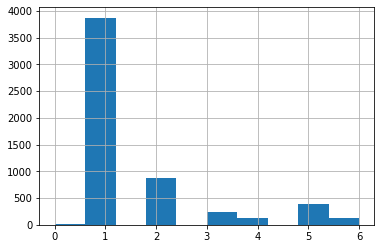

In [18]:
sample["passenger_count"].hist()

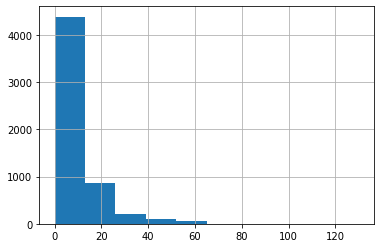

In [19]:
sample["fare_amount"].hist()

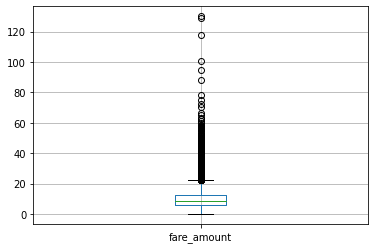

In [20]:
sample.boxplot("fare_amount")

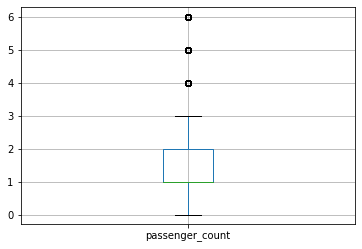

In [21]:
sample.boxplot("passenger_count")

In [87]:
df.printSchema()

root
 |-- key: timestamp (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)



In [99]:
rqt = "select 'fare_amount' as column_name, count(fare_amount) as count_null from ny_taxi where fare_amount is null " +\
      "union all "+\
      "select 'pickup_datetime' as column_name, count(pickup_datetime) as count_null from ny_taxi where pickup_datetime is null " +\
      "union all "+\
      "select 'pickup_longitude' as column_name, count(pickup_longitude) as count_null from ny_taxi where pickup_longitude is null " +\
      "union all "+\
      "select 'pickup_latitude' as column_name, count(pickup_latitude) as count_null from ny_taxi where pickup_latitude is null " +\
      "union all "+\
      "select 'dropoff_longitude' as column_name, count(dropoff_longitude) as count_null from ny_taxi where dropoff_longitude is null " +\
      "union all "+\
      "select 'dropoff_latitude' as column_name, count(dropoff_latitude) as count_null from ny_taxi where dropoff_latitude is null " +\
      "union all "+\
      "select 'passenger_count' as column_name, count(passenger_count) as count_null from ny_taxi where passenger_count is null "
spark.sql(rqt).show()

+-----------------+----------+
|      column_name|count_null|
+-----------------+----------+
|      fare_amount|         0|
|  pickup_datetime|         0|
| pickup_longitude|         0|
|  pickup_latitude|         0|
|dropoff_longitude|         0|
| dropoff_latitude|         0|
|  passenger_count|         0|
+-----------------+----------+



In [101]:
columns = ['key',
 'fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count']

In [102]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in columns]).show()

+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|key|fare_amount|pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|  0|          0|              0|               0|              0|              376|             376|              0|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+



In [22]:
df = df.na.drop(subset=["dropoff_longitude", "dropoff_latitude"])

# Feature extraction
- Havershine Distance
- Manhattan Distance
- Bearing between 2 long/latt
- Center Lattitude and Longitude between Pickup and dropoff


In [18]:
def havershine_distance(lat1, lng1, lat2, lng2):
  """
  Description:
    Calculated the Havershine Distance between 2 points on a sphere given their longitudes and lattitudes.
  Inputs:
    - lng1: longitude of the first point
    - lat1: latitude of the first point
    - lng2: longitude of the second point
    - lat2: latitude of the second point
  Output:
    - distance: FLoat
  """
  from math import radians, cos, sin, asin, sqrt
  lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])
  AVG_EARTH_RADIUS = 6371
  lat = lat1 - lat2
  lng = lng1 - lng2
  d = sin(lat * 5) ** 2 + cos(lat1) * cos(lat2) * sin(lng* 0.5) ** 2
  try :
    return round(2 * AVG_EARTH_RADIUS * asin(sqrt(d)), 4)
  except:
     return 0


In [24]:
udf_havershine_distance = udf(havershine_distance, DoubleType())
df2 = df.withColumn("havershine_distance", udf_havershine_distance("pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"))

In [77]:
df2.show()

+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-------------------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|havershine_distance|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-------------------+
|2009-06-15 17:26:21|        4.5|2009-06-15 17:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|            10.0557|
|2010-01-05 16:52:16|       16.9|2010-01-05 16:52:16|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|             78.677|
|2011-08-18 00:35:00|        5.7|2011-08-18 00:35:00|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|            11.9283|
|2012-04-21 04:30:42|        7.7|2012-04-21 04:30:42

In [78]:
def manhattan_distance(lat1, lon1, lat2, lon2):
  """
  Description:
    Calculated the Havershine Distance between 2 points on a sphere given their longitudes and lattitudes.
  Inputs:
    - lng1: longitude of the first point
    - lat1: latitude of the first point
    - lng2: longitude of the second point
    - lat2: latitude of the second point
  Output:
    - distance: FLoat
  """
  # Pickup coordinates
  p = np.stack([lat1, lon1], axis = 1)

  # Dropoff coordinates
  d = np.stack([lat2, lon2], axis = 1)

  theta1 = np.radians(-28.904)
  theta2 = np.radians(28.904)

  ## Rotation matrix
  R1 = np.array([[np.cos(theta1), np.sin(theta1)], 
                  [-np.sin(theta1), np.cos(theta1)]]
                )
  R2 = np.array([[np.cos(theta2), np.sin(theta2)], 
                  [-np.sin(theta2), np.cos(theta2)]]
                )

  # Rotate Pickup and Dropoff coordinates by -29 degress in World2
  pT = R1 @ p.T  
  dT = R1 @ d.T  

  # Coordinates of Hinge point in the rotated world 
  vT = np.stack((pT[0,:], dT[1,:]))
  # Coordinates of Hinge point in the real world 
  v = R2 @ vT
  """ Finally,

  Manhattan distance 
          = 
  Haversine dist between Pickup & Hingept
          +
  Haversine dist between Hinge pt & Dropoff location 
  """

  return (havershine_distance(p.T[0], p.T[1], v[0], v[1]) + 
          havershine_distance(v[0], v[1], d.T[0], d.T[1])
          )

In [19]:
def bearing_array(lat1, lng1, lat2, lng2): 
  """
  Description:
    Calculated the Bearing between 2 points on a sphere given their longitudes and lattitudes.
  Inputs:
    - lng1: longitude of the first point
    - lat1: latitude of the first point
    - lng2: longitude of the second point
    - lat2: latitude of the second point
  Output:
    - distance: FLoat
  """
  from math import cos, sin, atan2, degrees, radians
  AVG_EARTH_RADIUS = 6371 # in km 
  lng_delta_rad = radians(lng2 - lng1) 
  lat1, lng1, lat2, lng2 = map(radians, (lat1, lng1, lat2, lng2)) 
  y = sin(lng_delta_rad) * cos(lat2) 
  x = cos(lat1) * sin(lat2) - sin(lat1) * cos(lat2) * cos(lng_delta_rad) 
  return round(degrees(atan2(y, x)),4)

In [26]:
udf_bearing = udf(bearing_array, DoubleType())
df3 = df2.withColumn("bearing", udf_bearing(df["pickup_latitude"], df["pickup_longitude"], df["dropoff_latitude"], df["dropoff_longitude"]))
df3.show()

+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-------------------+---------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|havershine_distance|  bearing|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-------------------+---------+
|2009-06-15 17:26:21|        4.5|2009-06-15 17:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|            10.0557| 167.2405|
|2010-01-05 16:52:16|       16.9|2010-01-05 16:52:16|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|             78.677|  21.4984|
|2011-08-18 00:35:00|        5.7|2011-08-18 00:35:00|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|            11.9283|-14

In [27]:
df3.createOrReplaceTempView('ny_taxi_features')

In [82]:
spark.sql("select * from ny_taxi_features").show()

+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-------------------+---------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|havershine_distance|  bearing|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-------------------+---------+
|2009-06-15 17:26:21|        4.5|2009-06-15 17:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|            10.0557| 167.2405|
|2010-01-05 16:52:16|       16.9|2010-01-05 16:52:16|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|             78.677|  21.4984|
|2011-08-18 00:35:00|        5.7|2011-08-18 00:35:00|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|            11.9283|-14

In [28]:
rqt = "select " +\
      "date_format(nt.pickup_datetime, 'd') as pickup_day, " +\
      "date_format(nt.pickup_datetime, 'M') as pickup_month, " +\
      "date_format(nt.pickup_datetime, 'y') as pickup_year, " +\
      "date_format(nt.pickup_datetime, 'H') as pickup_hour, " +\
      "date_format(nt.pickup_datetime, 'm') as pickup_minute, " +\
      "dayofweek(nt.pickup_datetime) as pickup_day_of_week, " +\
      "nt.passenger_count as passenger_count, " +\
      "nt.havershine_distance as havershine_distance, " +\
      "nt.bearing as bearing, " +\
      "nt.fare_amount as fare_amount " +\
      "from ny_taxi_features nt"
df_final = spark.sql(rqt)

In [29]:
df_final.createOrReplaceTempView("df_final")

In [30]:
spark.sql("select * from df_final").show()

+----------+------------+-----------+-----------+-------------+------------------+---------------+-------------------+---------+-----------+
|pickup_day|pickup_month|pickup_year|pickup_hour|pickup_minute|pickup_day_of_week|passenger_count|havershine_distance|  bearing|fare_amount|
+----------+------------+-----------+-----------+-------------+------------------+---------------+-------------------+---------+-----------+
|        15|           6|       2009|         17|           26|                 2|              1|            10.0557| 167.2405|        4.5|
|         5|           1|       2010|         16|           52|                 3|              1|             78.677|  21.4984|       16.9|
|        18|           8|       2011|          0|           35|                 5|              2|            11.9283|-148.9668|        5.7|
|        21|           4|       2012|          4|           30|                 7|              1|            27.7445|  -7.6722|        7.7|
|         9| 

In [31]:
df_pd = df_final.sample(withReplacement=False, fraction=0.001, seed=1).toPandas()

In [32]:
df_pd

,pickup_day,pickup_month,pickup_year,pickup_hour,pickup_minute,pickup_day_of_week,passenger_count,havershine_distance,bearing,fare_amount
0,23,11,2013,12,57,7,1,0.0000,0.0000,5.00
1,27,8,2013,13,28,3,1,29.8085,-157.7391,9.50
2,6,10,2013,11,2,1,5,9.2891,142.8629,5.50
3,17,1,2009,0,15,7,2,22.0458,-136.0698,9.00
4,12,10,2009,21,33,2,1,10.4000,50.0435,5.70
...,...,...,...,...,...,...,...,...,...,...
55135,20,1,2013,1,20,1,1,17.3359,14.9119,7.50
55136,18,1,2010,15,54,2,1,8.7214,-5.4537,49.57
55137,15,3,2012,12,27,5,1,10.0989,176.7355,4.90
55138,6,2,2012,11,54,2,1,15.7762,16.0035,6.10


In [33]:
df_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55140 entries, 0 to 55139
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pickup_day           55140 non-null  object 
 1   pickup_month         55140 non-null  object 
 2   pickup_year          55140 non-null  object 
 3   pickup_hour          55140 non-null  object 
 4   pickup_minute        55140 non-null  object 
 5   pickup_day_of_week   55140 non-null  int32  
 6   passenger_count      55140 non-null  int32  
 7   havershine_distance  55140 non-null  float64
 8   bearing              55140 non-null  float64
 9   fare_amount          55140 non-null  float64
dtypes: float64(3), int32(2), object(5)
memory usage: 3.8+ MB


In [35]:
df_pd.describe()

,pickup_day_of_week,passenger_count,havershine_distance,bearing,fare_amount
count,55140.000000,55140.000000,55140.000000,55140.000000,55140.000000
mean,4.129325,1.699565,41.572712,-17.564619,11.398237
std,1.989621,1.320830,391.658520,103.524936,9.924255
min,1.000000,0.000000,0.000000,-179.993900,-14.500000
25%,2.000000,1.000000,7.587775,-126.644600,6.000000
50%,4.000000,1.000000,15.654200,2.369850,8.500000
75%,6.000000,2.000000,30.457300,48.110175,12.500000
max,7.000000,6.000000,10814.334000,180.000000,255.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fde5ca7bfd0>,
      dtype=object)

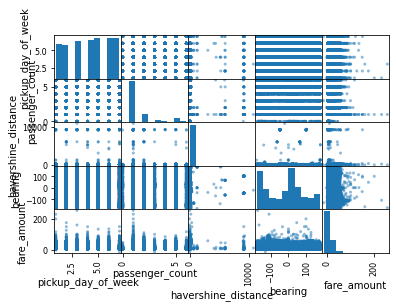

In [38]:
pd.plotting.scatter_matrix(df_pd)

In [44]:
corr = df_pd.corr()
corr.style.background_gradient()

,pickup_day_of_week,passenger_count,havershine_distance,bearing,fare_amount
pickup_day_of_week,1.000000,0.004088,-0.001531,-0.006663,-0.019245
passenger_count,0.004088,1.000000,0.004001,-0.007067,0.018954
havershine_distance,-0.001531,0.004001,1.000000,0.020828,0.068910
bearing,-0.006663,-0.007067,0.020828,1.000000,0.022923
fare_amount,-0.019245,0.018954,0.068910,0.022923,1.000000


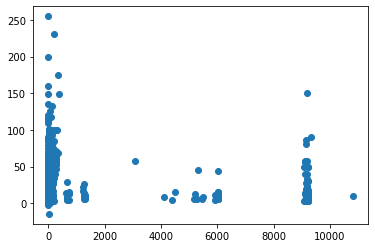

In [46]:
plt.scatter(df_pd["havershine_distance"], df_pd["fare_amount"])

# PySpark ML Pipeline


In [20]:
schema = StructType([
          StructField("key", TimestampType(), True),
          StructField("fare_amount", DoubleType(), True),
          StructField("pickup_datetime", TimestampType(), True),
          StructField("pickup_longitude", DoubleType(), True),
          StructField("pickup_latitude", DoubleType(), True),
          StructField("dropoff_longitude", DoubleType(), True),
          StructField("dropoff_latitude", DoubleType(), True),
          StructField("passenger_count", IntegerType(), True)
])
          

df = spark.read.csv("taxi_data/train.csv", header=True, schema=schema, enforceSchema=True, timestampFormat="yyyy-MM-dd HH:mm:ss")

In [21]:
from pyspark import keyword_only
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param, Params, TypeConverters
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml import Transformer

class CustomTransfomer(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
  @keyword_only
  def __init__(self, input_col=None, output_col=None):
    super(CustomTransfomer, self).__init__()
    #self._setDefault(input_col=None, output_col=None)
    kwargs = self._input_kwargs
    self.set_params(**kwargs)
  
  @keyword_only
  def set_params(self, input_col=None, output_col=None):
    kwargs = self._input_kwargs
    self._set(**kwargs)
  
  def _transform(self, df):
    # The custom action: concatenate the integer form of the doubles from the Vector
    df = df.replace(float('nan'), None)
    df = df.na.drop(subset=["dropoff_longitude", "dropoff_latitude"])
    udf_havershine_distance = udf(havershine_distance, DoubleType())
    df = df.withColumn("havershine_distance", udf_havershine_distance("pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"))
    udf_bearing = udf(bearing_array, DoubleType())
    df = df.withColumn("bearing", udf_bearing(df["pickup_latitude"], df["pickup_longitude"], df["dropoff_latitude"], df["dropoff_longitude"]))
    df.createOrReplaceTempView("ny_taxi_features")
    rqt = "select " +\
          "cast(date_format(nt.pickup_datetime, 'd') as integer) as pickup_day, " +\
          "cast(date_format(nt.pickup_datetime, 'M') as integer) as pickup_month, " +\
          "cast(date_format(nt.pickup_datetime, 'y') as integer) as pickup_year, " +\
          "cast(date_format(nt.pickup_datetime, 'H') as integer) as pickup_hour, " +\
          "cast(date_format(nt.pickup_datetime, 'm') as integer) as pickup_minute, " +\
          "cast(dayofweek(nt.pickup_datetime) as integer) as pickup_day_of_week, " +\
          "nt.passenger_count as passenger_count, " +\
          "nt.havershine_distance as havershine_distance, " +\
          "nt.bearing as bearing, " +\
          "nt.fare_amount as fare_amount " +\
          "from ny_taxi_features nt " +\
          "where nt.fare_amount>0" 
    df = spark.sql(rqt)
    #df = df.drop("key", "pickup_datetime", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude")
    return df

In [23]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

custom_transformer = CustomTransfomer()
assemblerInputs = ['pickup_day',
 'pickup_month',
 'pickup_year',
 'pickup_hour',
 'pickup_minute',
 'pickup_day_of_week',
 'passenger_count',
 'havershine_distance',
 'bearing']
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features", handleInvalid="skip")
pipeline = Pipeline(stages=[custom_transformer, assembler])
result = pipeline.fit(df).transform(df)
result.show()

+----------+------------+-----------+-----------+-------------+------------------+---------------+-------------------+---------+-----------+--------------------+
|pickup_day|pickup_month|pickup_year|pickup_hour|pickup_minute|pickup_day_of_week|passenger_count|havershine_distance|  bearing|fare_amount|            features|
+----------+------------+-----------+-----------+-------------+------------------+---------------+-------------------+---------+-----------+--------------------+
|        15|           6|       2009|         17|           26|                 2|              1|            10.0557| 167.2405|        4.5|[15.0,6.0,2009.0,...|
|         5|           1|       2010|         16|           52|                 3|              1|             78.677|  21.4984|       16.9|[5.0,1.0,2010.0,1...|
|        18|           8|       2011|          0|           35|                 5|              2|            11.9283|-148.9668|        5.7|[18.0,8.0,2011.0,...|
|        21|           4|   

In [24]:
dataset = result.select(["features", "fare_amount"])
dataset.show()

+--------------------+-----------+
|            features|fare_amount|
+--------------------+-----------+
|[15.0,6.0,2009.0,...|        4.5|
|[5.0,1.0,2010.0,1...|       16.9|
|[18.0,8.0,2011.0,...|        5.7|
|[21.0,4.0,2012.0,...|        7.7|
|[9.0,3.0,2010.0,7...|        5.3|
|[6.0,1.0,2011.0,9...|       12.1|
|[20.0,11.0,2012.0...|        7.5|
|[4.0,1.0,2012.0,1...|       16.5|
|[3.0,12.0,2012.0,...|        9.0|
|[2.0,9.0,2009.0,1...|        8.9|
|[8.0,4.0,2012.0,7...|        5.3|
|[24.0,12.0,2012.0...|        5.5|
|[6.0,11.0,2009.0,...|        4.1|
|[2.0,7.0,2013.0,1...|        7.0|
|[5.0,4.0,2011.0,1...|        7.7|
|[23.0,11.0,2013.0...|        5.0|
|[19.0,2.0,2014.0,...|       12.5|
|[22.0,7.0,2009.0,...|        5.3|
|[7.0,7.0,2010.0,1...|        5.3|
|[6.0,12.0,2014.0,...|        4.0|
+--------------------+-----------+
only showing top 20 rows



In [25]:
(trainingData, testData) = dataset.randomSplit([0.9, 0.1], seed=100)
#print(trainingData.count())
#print(testData.count())

In [26]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(labelCol="fare_amount" , featuresCol="features")
print("Training ...")
rfModel = rf.fit(trainingData)
print("Predicting ...")
predictions = rfModel.transform(testData)

Training ...
Predicting ...


In [27]:
predictions.show()

+--------------------+-----------+------------------+
|            features|fare_amount|        prediction|
+--------------------+-----------+------------------+
|[1.0,1.0,2009.0,0...|        5.4| 8.270952766467454|
|[1.0,1.0,2009.0,0...|       16.5|12.994154791079248|
|[1.0,1.0,2009.0,0...|       11.0| 9.319723822463782|
|[1.0,1.0,2009.0,1...|       10.6|13.287201202262267|
|[1.0,1.0,2009.0,1...|       10.2| 11.80998768773447|
|[1.0,1.0,2009.0,1...|        7.0| 9.796039630493459|
|[1.0,1.0,2009.0,2...|        5.8| 8.161220743816106|
|[1.0,1.0,2009.0,3...|       33.8|28.788450591496485|
|[1.0,1.0,2009.0,4...|        6.5| 8.278858856134768|
|[1.0,1.0,2009.0,4...|        7.4| 9.748221713047931|
|[1.0,1.0,2009.0,7...|       28.9| 34.14710179752781|
|[1.0,1.0,2009.0,7...|       28.9|12.018719787830548|
|[1.0,1.0,2009.0,9...|        4.9| 8.097565029331747|
|[1.0,1.0,2009.0,1...|        7.7|10.461699782474344|
|[1.0,1.0,2009.0,1...|       10.1|11.008774807087303|
|[1.0,1.0,2009.0,1...|      

In [28]:
from pyspark.mllib.evaluation import RegressionMetrics
metrics = RegressionMetrics(predictions.select("fare_amount", "prediction").rdd.map(lambda x: (x.fare_amount, x.prediction) ))

# Root mean squared error
print("RMSE = %s" % metrics.rootMeanSquaredError)
# Mean absolute error
print("MAE = %s" % metrics.meanAbsoluteError)
# R-squared
print("R-squared = %s" % metrics.r2)
# Explained Variance
print("Explained variance = %s" % metrics.explainedVariance)

RMSE = 7.051743748097276
MAE = 3.8748460254197985
R-squared = -0.5503243141210941
Explained variance = 95.711594748864


In [29]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")

# Root Mean Square Error
rmse = eval.evaluate(predictions)
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = eval.evaluate(predictions, {eval.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = eval.evaluate(predictions, {eval.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = eval.evaluate(predictions, {eval.metricName: "r2"})
print("r2: %.3f" %r2)



RMSE: 7.052
MSE: 49.727
MAE: 3.875
r2: 0.480
